In [ ]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from numpy.polynomial.polynomial import Polynomial
from sklearn.ensemble import RandomForestRegressor

# Pertanyaan Bisnis

1. Bagaimana latar belakang demografis pada setiap pengguna?
2. Bagaimana kesimpulan kebiasaan pengguna dalam berbelanja?
3. Dari data-data yang sudah dikumpulkan, berapa banyak promosi yang efektif dilakukan untuk setiap pengguna? (Pertanyaan Target)

# Data Wrangling

## Import Data

In [ ]:
trainFeatures = pd.read_csv('data/train_features.csv')
testFeatures = pd.read_csv('data/test_features.csv')
trainLabels = pd.read_csv('data/train_labels.csv')
example = pd.read_csv('data/submission_format.csv')

## Display Data

### Data Train Features

In [ ]:
trainFeatures.head()

In [ ]:
trainFeatures.shape

### Data Train Labels

In [ ]:
trainLabels.head()

In [ ]:
trainLabels.shape

### Data Test Features

In [ ]:
testFeatures.head()

In [ ]:
example.head()

## Concatenate Data Training

Dari data training yang tersedia, perlu dilakukan penggabungan dari kedua data yaitu **Train Features** dan **Train Labels**.

In [ ]:
dataTraining = pd.concat([trainFeatures, trainLabels], axis=1)

In [ ]:
print("Banyak Data Training:", dataTraining.shape[0])
dataTraining.head()

# Data Assessing

## Informasi Umum Data Training

In [ ]:
dataTraining.info()

In [ ]:
dataTraining.describe()

## Cek Nilai Null Data Training

In [ ]:
dataTraining.isnull().sum()

## Cek Nilai Duplikat Dataset Train Features

In [ ]:
dataTraining.duplicated().sum()

# Data Cleaning

## Kolom Pendidikan

In [ ]:
# Cek Nilai Unique
dataTraining['pendidikan'].unique()

Terdapat dua nilai salah yaitu nan dan '5'. Maka perlu dibersihkan pada dua nilai tersebut.

### Olah Data dengan Nilai Unique '5'

In [ ]:
# Ambil contoh nilai pada kolom pendidikan dengan nilai '5'
dataTraining[dataTraining['pendidikan'] == '5'].head()

In [ ]:
# Mengambil indeks data dengan nilai unique '5'
dropPendidikan = dataTraining[dataTraining['pendidikan'] == '5'].index
# Menghapus nilai dengan indeks tersebut
dataTraining.drop(dropPendidikan, inplace=True)

Saat ini nilai dengan inputan '5' sudah terhapus, karena hanya terdapat 2 data saja maka dapat dikatakan aman untuk dihapus.

Selanjutnya yaitu menangani data dengan inputan nan. Untuk langkah yang diambil yaitu mengecek seberapa banyak nilai nan yang ada. Jika jumlah terbilang sedikit, langkah yang diambil adalah menghapus nilai tersebut (seperti pada inputan '5' sebelumnya). Namun, jika jumlahnya terbilang cukup banyak, maka langkah yang diambil yaitu mengubah setiap nilai nan menjadi nilai modus pada kolom **pendidikan**.

### Olah Data dengan Nilai Unique NaN

In [ ]:
# Mengambil sample data dengan inputan nan
dataNanPendidikan = dataTraining[dataTraining['pendidikan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPendidikan.shape[0], '\n')
print('Dengan sample data sebagai berikut: ')
dataNanPendidikan.sample(10)

Dikarenakan jumlah dari data nan cukup banyak, maka akan dilakukan pengubahan isi dengan data modus pada kolom **pendidikan**.

In [ ]:
# Mengambil jumlah isi terbanyak pada kolom pendidikan
modePendidikan = dataTraining['pendidikan'].mode()[0]
print('Nilai dengan modus terbanyak adalah', modePendidikan)

In [ ]:
# Mengubah nilai nan menjadi nilai modus
dataTraining['pendidikan'] = dataTraining['pendidikan'].fillna(modePendidikan)

In [ ]:
# Cek ulang nilai unique
dataTraining['pendidikan'].unique()

Pada saat ini, kondisi kolom **pendidikan** sudah normal.

## Kolom Status Pernikahan

In [ ]:
# Cek Nilai Unique
dataTraining['status_pernikahan'].unique()

Mirip dengan kolom Pendidikan, terdapat dua nilai tidak sesuai pada kolom **Status Pernikahan** yaitu '5' dan nan. Maka perlu dilakukan proses yang sama dengan kolom Pendidikan yaitu meninjau setiap invalid value yang ada untuk dilakukan langkah lebih lanjut.

### Olah Data dengan Nilai Unique '5'

In [ ]:
# Mengambil sample data dengan nilai unique '5'
dataTraining[dataTraining['status_pernikahan'] == '5']

Dikarenakan hanya terdapat satu nilai saja dengan value '5', maka dapat dihapus saja karena tidak terlalu berpengaruh terhadap keseluruhan data.

In [ ]:
# Mengambil data dengan nilai unique '5'
dropStatusNikah = dataTraining[dataTraining['status_pernikahan'] == '5'].index
# Menghapus data
dataTraining.drop(dropStatusNikah, inplace=True)


### Olah Data dengan Nilai Unique NaN

In [ ]:
# Mengambil sample data dengan inputan nan
dataNanPernikahan = dataTraining[dataTraining['status_pernikahan'].isnull()]

# Mengecek Banyak Baris Data
print('Banyak Data dengan inputan nan:', dataNanPernikahan.shape[0], '\n')
print('Dengan sample data sebagai berikut: ')
dataNanPernikahan.sample(10)

Dikarenakan jumlah dari data nan cukup banyak, maka akan dilakukan pengubahan isi data nan dengan analisis lebih lanjut pada kolom-kolom yang berpotensi memiliki korelasi dengan kolom **status pernikahan**. 

Yaitu dengan melihat kolom **jumlah anak balita** dan **jumlah anak remaja** dengan asumsi jika memiliki nilai lebih dari 0 dari kedua kolom tersebut, maka akan diubah menjadi "Menikah".

In [ ]:
# Ubah NaN menjadi String Terlebih Dahulu
dataTraining['status_pernikahan'].fillna('kosong', inplace=True)

# Buat Fungsi
def ubahPernikahan(row):
    if row['status_pernikahan'] == 'kosong':
        if row['jumlah_anak_balita'] > 0 or row['jumlah_anak_remaja'] > 0:
            return 'Menikah'
        else:
            return 'Sendiri'
    else:
        return row['status_pernikahan']

dataTraining['status_pernikahan'] = dataTraining.apply(ubahPernikahan, axis=1)

In [ ]:
dataTraining['status_pernikahan'].unique()

Saat ini nilai unique pada kolom **status pernikahan** sudah normal dan tidak ada nilai nan.

## Kolom Pendapatan

In [ ]:
dataTraining.pendapatan.sample(5)

### Cek Nilai Statistik 

In [ ]:
dataTraining.describe()

### Pengecekan Nilai Null

Dari hasil analisis sebelumnya, terlihat bahwa terdapat nilai null pada kolom ini.

In [ ]:
nullPendapatan = dataTraining[dataTraining['pendapatan'].isnull()]
nullPendapatan.head(10)

In [ ]:
dataTraining.sample(10)

Yang dilakukan adalah menggunakan interpolasi polinomial untuk menutup setiap nilai NaN yang ada dengan titik terdekat data ke data lainnya secara linear.

In [ ]:
# Data x dan y yang tidak null
x_known = dataTraining.index[~dataTraining['pendapatan'].isnull()]
y_known = dataTraining.loc[x_known, 'pendapatan']

# Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
poly_interp = Polynomial.fit(x_known, y_known, deg=2)

# Memasang indeks titik data yang akan diisi (NaN)
fill_indices = dataTraining.index[dataTraining['pendapatan'].isnull()]

# Isi nilai-nilai NaN dengan hasil interpolasi polinomial
dataTraining.loc[fill_indices, 'pendapatan'] = poly_interp(fill_indices)


Pada saat ini sudah tidak terdapat nilai NaN lagi pada kolom **pendapatan**, sehingga dapat dilanjutkan pada proses analisis selanjutnya.

In [ ]:
# Tampilan statistik kolom pendapatan
dataTraining.pendapatan.describe()

## Kolom Jumlah Anak Balita

### Cek Nilai Unique

In [ ]:
dataTraining['jumlah_anak_balita'].unique()

Pada pengecekan nilai unique di atas, ditemukan nilai NaN yang perlu diganti dengan nilai lain.

### Hapus Nilai Null

In [ ]:
dataTraining['jumlah_anak_balita'].fillna(0, inplace=True)
dataTraining['jumlah_anak_balita'] = dataTraining['jumlah_anak_balita'].astype(int)
print(dataTraining['jumlah_anak_balita'].dtype)

In [ ]:
# Cek Nilai Unique Ulang
dataTraining['jumlah_anak_balita'].unique()

Pada proses ini, langkah yang diambil adalah mengubah nilai NaN menjadi **0** dengan asumsi setiap nilai NaN diartikan baris data penduduk tersebut memiliki jumlah anak balita sebanyak **0**.

## Kolom Jumlah Anak Remaja

### Cek Nilai Unique

In [ ]:
dataTraining['jumlah_anak_remaja'].unique()

Sama seperti pada kasus kolom *jumlah anak balita*, terdapat nilai NaN pada kolom *jumlah anak remaja* yang perlu diubah dengan nilai lainnya.

### Hapus Nilai Null

In [ ]:
dataTraining['jumlah_anak_remaja'].fillna(0, inplace=True)
dataTraining['jumlah_anak_remaja'] = dataTraining['jumlah_anak_remaja'].astype(int)
print(dataTraining['jumlah_anak_remaja'].dtype)

In [ ]:
# Cek Nilai Unique Ulang
dataTraining['jumlah_anak_remaja'].unique()

Hasil pada kolom *jumlah anak remaja* juga mirip dengan hasil kolom *jumlah anak balita*, yaitu dengan mengubah nilai NaN dengan nilai **0**. Sebagai asumsi bahwa nilai NaN berarti baris data penduduk tersebut tidak memiliki anak remaja.

## Kolom Terakhir Belanja

### Cek Nilai Unique

In [ ]:
dataTraining['terakhir_belanja'].unique()

Pada pengecekan nilai unique, hasilnya terdapat nilai NaN yang terkandung didalam kolom *terakhir belanja*. Maka perlu dilakukan pengecekan batas minimum dan maksimum data serta nilai statistik lainnya seperti rata-rata untuk mengubah nilai NaN ini dengan sajian nilai Unique yang lebih rapi.

### Cek Nilai Min dan Max

In [ ]:
nilaiMax = dataTraining.terakhir_belanja.max()
nilaiMin = dataTraining.terakhir_belanja.min()

print('Nilai maksimal dari kolom terakhir belanja adalah', nilaiMax)
print('Nilai minimal dari kolom terakhir belanja adalah', nilaiMin)

Dikarenakan tidak adanya acuan data tambahan dari kolom *terakhir belanja*, maka langkah yang diambil adalah mengubah setiap nilai NaN menjadi nilai rata-rata.

### Ubah Nilai Null dengan Rata-Rata

In [ ]:
rata2 = dataTraining['terakhir_belanja'].mean()
rata2

Didapatkan nilai **47.23338824821526** yang perlu dibulatkan, untuk mengubah nilai NaN dengan nilai ini.

In [ ]:
dataTraining['terakhir_belanja'] = dataTraining['terakhir_belanja'].fillna(rata2)
dataTraining['terakhir_belanja'] = dataTraining['terakhir_belanja'].astype(int)
print(dataTraining['terakhir_belanja'].dtype)

Pembulatan nilai pada kolom *terakhir belanja* dilakukan dengan cara pengubahan tipe data dari float menjadi integer.

In [ ]:
# Cek Ulang Nilai Unique
nilaiTerurut = np.sort(dataTraining['terakhir_belanja'].unique())
nilaiTerurut

## Kolom Belanja Buah

Pada kolom **belanja buah**, juga masih terdapat nilai NaN yang harus dipenuhi. Untuk langkah yang diambil yaitu mengisi dengan mempertimbangkan kolom lain yang secara logis masih memiliki hubungan dengan kolom **belanja_buah**. Hal ini bertujuan agar pengisian data bervariasi tetapi masih memiliki alasan yang masuk jelas. Kolom yang dipilih adalah **pendapatan**.

In [ ]:
dataTraining.head()

In [ ]:
dataTraining.belanja_buah.isna().sum()

### Pengisian Nilai NaN

Pengisian nilai NaN dilakukan dengan cara mengambil sampel nilai pendapatan pada kolom **pendapatan** berdasarkan segmentasi pendapatan pada kolom **segmen_pendapatan**. Setelah itu, dilakukan prediksi yang hasilnya akan dimasukkan sebagai pengganti nilai NaN. 

Untuk fitur x diambil dari kolom **pendapatan** (non null) dan fitur y diambil dari kolom **belanja buah** hanya nilai yang non null saja. Prediksi dilakukan menggunakan *Random Forest*.

In [ ]:
# Data x dan y yang tidak null
x_known = dataTraining.index[~dataTraining['belanja_buah'].isnull()]
y_known = dataTraining.loc[x_known, 'belanja_buah']

# Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
poly_interp = Polynomial.fit(x_known, y_known, deg=2)

# Memasang indeks titik data yang akan diisi (NaN)
fill_indices = dataTraining.index[dataTraining['belanja_buah'].isnull()]

# Isi nilai-nilai NaN dengan hasil interpolasi polinomial
dataTraining.loc[fill_indices, 'belanja_buah'] = poly_interp(fill_indices)

In [ ]:
dataTraining.belanja_buah.isna().sum()

## Kolom Belanja Daging

In [ ]:
# Data x dan y yang tidak null
x_known = dataTraining.index[~dataTraining['belanja_daging'].isnull()]
y_known = dataTraining.loc[x_known, 'belanja_daging']

# Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
poly_interp = Polynomial.fit(x_known, y_known, deg=2)

# Memasang indeks titik data yang akan diisi (NaN)
fill_indices = dataTraining.index[dataTraining['belanja_daging'].isnull()]

# Isi nilai-nilai NaN dengan hasil interpolasi polinomial
dataTraining.loc[fill_indices, 'belanja_daging'] = poly_interp(fill_indices)

In [ ]:
dataTraining.belanja_daging.isna().sum()

## Kolom Belanja Ikan

In [ ]:
# Data x dan y yang tidak null
x_known = dataTraining.index[~dataTraining['belanja_buah'].isnull()]
y_known = dataTraining.loc[x_known, 'belanja_buah']

# Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
poly_interp = Polynomial.fit(x_known, y_known, deg=2)

# Memasang indeks titik data yang akan diisi (NaN)
fill_indices = dataTraining.index[dataTraining['belanja_buah'].isnull()]

# Isi nilai-nilai NaN dengan hasil interpolasi polinomial
dataTraining.loc[fill_indices, 'belanja_buah'] = poly_interp(fill_indices)

In [ ]:
trainFeatures.belanja_ikan.isna().sum()

## Kolom Belanja Kue

In [ ]:
# Data x dan y yang tidak null
x_known = dataTraining.index[~dataTraining['belanja_kue'].isnull()]
y_known = dataTraining.loc[x_known, 'belanja_kue']

# Buat objek interpolasi polinomial orde rendah (misalnya, orde 2)
poly_interp = Polynomial.fit(x_known, y_known, deg=2)

# Memasang indeks titik data yang akan diisi (NaN)
fill_indices = dataTraining.index[dataTraining['belanja_kue'].isnull()]

# Isi nilai-nilai NaN dengan hasil interpolasi polinomial
dataTraining.loc[fill_indices, 'belanja_kue'] = poly_interp(fill_indices)

In [ ]:
dataTraining.belanja_ikan.isna().sum()

## Kolom Pembelian Diskon

In [ ]:
dataTraining.pembelian_diskon.isna().sum()

In [ ]:
dataTraining.pembelian_diskon.describe()

In [ ]:
kuartilPendapatan = dataTraining['pendapatan'].quantile([0.25, 0.5, 0.75])

dataTraining['segmentasi_pendapatan'] = pd.cut(dataTraining['pendapatan'], 
                                                bins=[0, kuartilPendapatan.iloc[0], kuartilPendapatan.iloc[1], 
                                                      kuartilPendapatan.iloc[2], dataTraining['pendapatan'].max()],
                                                labels=['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'])

dataTraining

In [ ]:
for segmen in dataTraining['segmentasi_pendapatan'].unique():
    # Filter DataFrame berdasarkan segmen pendapatan
    df_segmen = dataTraining[dataTraining['segmentasi_pendapatan'] == segmen]
    
    # Mengambil nilai modus dari kolom 'pembelian_diskon' pada segmen saat ini
    mayorSegmen = df_segmen['pembelian_diskon'].mean()

    # Mengisi nilai null di kolom 'pembelian_diskon' berdasarkan segmentasi pendapatan dengan nilai modus
    dataTraining.loc[dataTraining['segmentasi_pendapatan'] == segmen, 'pembelian_diskon'] = dataTraining.loc[dataTraining['segmentasi_pendapatan'] == segmen, 'pembelian_diskon'].fillna(mayorSegmen)

In [ ]:
dataTraining.pembelian_diskon.isna().sum()

In [ ]:
Q1 = dataTraining['pembelian_diskon'].quantile(0.25)
Q3 = dataTraining['pembelian_diskon'].quantile(0.75)
IQR = Q3 - Q1

Upper_Fence = Q3 + 1.5 * IQR
Lower_Fence = Q1 - 1.5 * IQR

outliers = dataTraining[(dataTraining['pembelian_diskon'] < Lower_Fence) | (dataTraining['pembelian_diskon'] > Upper_Fence)]['pembelian_diskon']
len(outliers)


In [ ]:
plt.boxplot(dataTraining['pembelian_diskon'], vert=False)
plt.xlabel('Belanja Buah')
plt.ylabel('Jumlah')
plt.title('Diagram Boxplot pembelian_diskon')
plt.show()

In [ ]:
# Plot histogram
plt.hist(dataTraining['pembelian_diskon'], bins=10, color='skyblue', edgecolor='black')

# Label sumbu dan judul
plt.xlabel('pembelian_diskon')
plt.ylabel('Frekuensi')
plt.title('Histogram pembelian_diskon')

Saat ini kolom **belanja buah** sudah tidak ada nilai null lagi

## Kolom Pembelian Web

In [ ]:
for segmen in dataTraining['segmentasi_pendapatan'].unique():
    # Filter DataFrame berdasarkan segmen pendapatan
    df_segmen = dataTraining[dataTraining['segmentasi_pendapatan'] == segmen]
    
    # Mengambil nilai modus dari kolom 'pembelian_diskon' pada segmen saat ini
    mayorSegmen = df_segmen['pembelian_web'].mean()

    # Mengisi nilai null di kolom 'pembelian_diskon' berdasarkan segmentasi pendapatan dengan nilai modus
    dataTraining.loc[dataTraining['segmentasi_pendapatan'] == segmen, 'pembelian_web'] = dataTraining.loc[dataTraining['segmentasi_pendapatan'] == segmen, 'pembelian_web'].fillna(mayorSegmen)

In [ ]:
Q1 = dataTraining['pembelian_web'].quantile(0.25)
Q3 = dataTraining['pembelian_web'].quantile(0.75)
IQR = Q3 - Q1

Upper_Fence = Q3 + 1.5 * IQR
Lower_Fence = Q1 - 1.5 * IQR

outliers = dataTraining[(dataTraining['pembelian_web'] < Lower_Fence) | (dataTraining['pembelian_web'] > Upper_Fence)]['pembelian_web']
len(outliers)

In [ ]:
plt.boxplot(dataTraining['pembelian_web'], vert=False)
plt.xlabel('Belanja Buah')
plt.ylabel('Jumlah')
plt.title('Diagram Boxplot pembelian_diskon')
plt.show()

In [ ]:
# Plot histogram
plt.hist(dataTraining['pembelian_web'], bins=10, color='skyblue', edgecolor='black')

# Label sumbu dan judul
plt.xlabel('pembelian_diskon')
plt.ylabel('Frekuensi')
plt.title('Histogram pembelian_diskon')

## Kolom Pembelian Toko

In [ ]:
for segmen in dataTraining['segmentasi_pendapatan'].unique():
    # Filter DataFrame berdasarkan segmen pendapatan
    df_segmen = dataTraining[dataTraining['segmentasi_pendapatan'] == segmen]
    
    # Mengambil nilai modus dari kolom 'pembelian_diskon' pada segmen saat ini
    mayorSegmen = df_segmen['pembelian_toko'].mean()

    # Mengisi nilai null di kolom 'pembelian_diskon' berdasarkan segmentasi pendapatan dengan nilai modus
    dataTraining.loc[dataTraining['segmentasi_pendapatan'] == segmen, 'pembelian_toko'] = dataTraining.loc[dataTraining['segmentasi_pendapatan'] == segmen, 'pembelian_toko'].fillna(mayorSegmen)

In [ ]:
Q1 = dataTraining['pembelian_toko'].quantile(0.25)
Q3 = dataTraining['pembelian_toko'].quantile(0.75)
IQR = Q3 - Q1

Upper_Fence = Q3 + 1.5 * IQR
Lower_Fence = Q1 - 1.5 * IQR

outliers = dataTraining[(dataTraining['pembelian_toko'] < Lower_Fence) | (dataTraining['pembelian_toko'] > Upper_Fence)]['pembelian_toko']
len(outliers)

In [ ]:
plt.boxplot(dataTraining['pembelian_toko'], vert=False)
plt.xlabel('Belanja Buah')
plt.ylabel('Jumlah')
plt.title('Diagram Boxplot pembelian_diskon')
plt.show()

In [ ]:
# Plot histogram
plt.hist(dataTraining['pembelian_toko'], bins=10, color='skyblue', edgecolor='black')

# Label sumbu dan judul
plt.xlabel('pembelian_diskon')
plt.ylabel('Frekuensi')
plt.title('Histogram pembelian_diskon')

## Kolom Keluhan

In [ ]:
dataTraining.keluhan.isna().sum()

In [ ]:
dataTraining['keluhan'].fillna(0, inplace=True)

In [ ]:
dataTraining.keluhan.isna().sum()

## Kolom Tanggal Menjadi Anggota

In [ ]:
dataTraining.tanggal_menjadi_anggota.isna().sum()

In [ ]:
dataTraining['tanggal_menjadi_anggota'].fillna("Unknown", inplace=True)

In [ ]:
dataTraining.tanggal_menjadi_anggota.isna().sum()

In [ ]:
dataTraining = round(dataTraining)
dataTraining.head()

## Kolom Segmentasi Pendapatan

In [ ]:
dataTraining.segmentasi_pendapatan.isna().sum()

Sebab tidak terdapat nilai NaN, maka tidak perlu adanya penghapusan nilai outliers di kolom ini.

## Kolom Jumlah Promosi

In [ ]:
dataTraining.jumlah_promosi.isna().sum()

Sebab tidak terdapat nilai NaN, maka tidak perlu adanya penghapusan nilai outliers di kolom ini.

# Exploratory Data Analysis (EDA)

## Pertanyaan Analisis
Dari pertanyaan-pertanyaan bisnis yang sudah didefinisikan, berikut adalah pertanyaan-pertanyaan guna menganalisis setiap pertanyaan bisnis yang ada:

1. Rentang usia berapa saja pengguna yang terdata pada dataset?
2. Berapa porsi berdasarkan pendidikan terakhir pengguna?
3. Status pernikahan apa saja pengguna yang terdata pada dataset?
4. Berapa rata-rata pengguna yang sudah memiliki anak dan berapa jumlah rata-rata anak yang dimiliki?
5. Berapa rata-rata pendapatan dari segmentasi pendapatan yang ada?
6. Dari segmentasi pendapatan, berapa rata-rata pengeluaran pengguna untuk belanja?
7. Bagaimana hubungan keluhan pengguna berdasarkan cara pembelian yang dilakukan?
8. Bagaimana distribusi pendaftaran anggota dari hasil analisis statistik dan demografis yang sudah dilakukan?
9. Bagaimana kesimpulan jumlah promosi yang sudah dilakukan pada setiap pengguna untuk dilakukan promosi ke pengguna baru?

## Analisis Outliers

Sebelum melakukan analisis lebih lanjut, dilakukan analisis outliers untuk menghilangkan nilai-nilai diluar rentang yang dapat mempengaruhi hasil dari analisis.

### Cek Nilai Outliers dengan Box Plot

In [ ]:
numFeatures = dataTraining.select_dtypes(include='number').columns

# Tentukan ukuran kanvas subplot
numPlots = len(numFeatures)
numRows = numPlots // 2 + numPlots % 2  # Hitung jumlah baris
fig, axes = plt.subplots(nrows=numRows, ncols=2, figsize=(12, 20), 
                         gridspec_kw={'height_ratios': [1]*numRows})  # Set tinggi setiap baris sama

# Looping melalui kolom numerik
for i, column in enumerate(numFeatures):
    row = i // 2
    col = i % 2
    sns.boxplot(x=dataTraining[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Menghapus subplot yang tidak digunakan jika jumlah kolom ganjil
if numPlots % 2 != 0:
    fig.delaxes(axes[numRows-1, 1])

plt.tight_layout()
plt.show()

Dari hasil analisis banyak outliers di atas, terlihat bahwa ada beberapa kolom yang masih terdapat nilai outliers yang perlu ditangani. Namun juga perlu adanya seleksi lagi kolom-kolom yang perlu ditangani dan juga yang tidak. 

Untuk kolom yang tidak perlu yaitu kolom-kolom numerik dengan nilai terbilang sedikit variasinya.

In [ ]:
ignoredColumn = ['keluhan', 'jumlah_anak_balita', 'jumlah_anak_remaja', 'tahun_kelahiran']
interpolateColumn = ['belanja_buah', 'belanja_ikan', 'belanja_daging', 'belanja_kue']

# Fungsi untuk menghapus outlier menggunakan pendekatan IQR
def replace_outliers_with_interpolation(df):
    cleaned_data = df.copy()  # Salin dataframe asli untuk dimodifikasi
    
    # Loop melalui setiap kolom numerik
    for column in df.select_dtypes(include='number').columns:
        if column not in ignoredColumn:  # Lewati kolom yang diabaikan
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            if column in interpolateColumn:
                # Interpolasi nilai outliers
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
                interpolated_values = (outliers[column] - lower_bound) / (upper_bound - lower_bound) * (Q3 - Q1) + Q1
                cleaned_data.loc[outliers.index, column] = interpolated_values
            cleaned_data[column] = cleaned_data[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return cleaned_data

# Hapus outlier menggunakan pendekatan IQR untuk setiap kolom (kecuali yang diabaikan)
cleanedTraining = replace_outliers_with_interpolation(dataTraining)

In [ ]:
cleanedTraining.shape[0]

In [ ]:
numFeatures = cleanedTraining.select_dtypes(include='number').columns

# Tentukan ukuran kanvas subplot
numPlots = len(numFeatures)
numRows = numPlots // 2 + numPlots % 2  # Hitung jumlah baris
fig, axes = plt.subplots(nrows=numRows, ncols=2, figsize=(12, 20), 
                         gridspec_kw={'height_ratios': [1]*numRows})  # Set tinggi setiap baris sama

# Looping melalui kolom numerik
for i, column in enumerate(numFeatures):
    row = i // 2
    col = i % 2
    sns.boxplot(x=cleanedTraining[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Menghapus subplot yang tidak digunakan jika jumlah kolom ganjil
if numPlots % 2 != 0:
    fig.delaxes(axes[numRows-1, 1])

plt.tight_layout()
plt.show()

In [ ]:
cleanedTraining.sample(10)

Setelah dilakukan proses penghapusan outliers, saat ini sudah tidak ada outliers pada setiap kolom di data training.

## Jawab Pertanyaan Analisis dan Univariate Analysis

Pada sesi ini, menjawab pertanyaan analisis dengan berbagai langkah analisis disertai dengan Univariate Analysis

### Pertanyaan 1

Pada pertanyaan 1, perlu melakukan analisa pada kolom **Tahun Kelahiran** untuk mengetahui usia berapa saja setiap pengguna yang terdata pada dataset.

In [ ]:
# Mengambil nilai tahun sekarang
yearNow = datetime.now().year
# Mengurangi tahun kelahiran dengan tahun sekarang, masukkan dalam kolom baru
cleanedTraining['usia'] = yearNow - cleanedTraining['tahun_kelahiran']

Setelah mendapatkan angka usia pada setiap pengguna, selanjutnya adalah membuat rentang usia.

In [ ]:
# Membuat batas rentang usia
limitAges = [24, 30, 70, float('inf')]

# Membuat label rentang usia
labelAges = ['Remaja', 'Dewasa', 'Lanjut Usia']

# Membuat kolom baru rentang usia
cleanedTraining['rentang_usia'] = pd.cut(cleanedTraining['usia'], bins=limitAges, labels=labelAges)

Setelah dilakukan pembuatan rentang usia, maka perlu dilakukan proses validasi pada nilai-nilai yang ada dan berkaitan dengan pertanyaan 1.

In [ ]:
print('Usia paling muda adalah', cleanedTraining.usia.min())
print('Usia paling tua adalah', cleanedTraining.usia.max())

Disini terdeteksi terdapat ketidaktepatan pada data yang sudah ada, yaitu adanya usia yang tidak logis. Maka perlu dilakukan analisis lebih lanjut pada data kolom Tahun **Kelahiran**, **Usia**, dan **Rentang Usia**.

In [ ]:
# Grouping berdasarkan rentang usia
grpAgeRange = cleanedTraining[cleanedTraining['rentang_usia'] == 'Lanjut Usia']

# Mengurutkan setiap nilai unik di kolom usia untuk menentukan batas maksimal usia
print(np.sort(grpAgeRange['usia'].unique()))

# Menampilkan banyak data di atas batas maksimal
print("Banyak data di atas batas maksimal", len(cleanedTraining[cleanedTraining['usia'] > 84]))

Dari hasil analisis di atas, dari penentuan batas maksimal usia lansia adalah **84** dengan banyak data di atas batas maksimal (Invalid Value) adalah **16**. Maka dapat dilakukan penghapusan data di atas batas maksimal.

In [ ]:
cleanedTraining = cleanedTraining[cleanedTraining['usia'] <= 84]

Setelah dilakukan pembersihan, dapat disimpulkan rentang usia berdasarkan usia pengguna adalah sebagai berikut:

In [ ]:
grpAges = cleanedTraining.groupby('rentang_usia').agg({
    'usia': ['count', 'min', 'max']
})

for rentang, nilai in grpAges.iterrows():
    print(f"Pada rentang usia {rentang} yaitu usia {nilai['usia']['min']}-{nilai['usia']['max']}, terdapat {nilai['usia']['count']} pengguna.")

In [ ]:
# Plotting bar chart
plt.figure(figsize=(13, 6))
bars = grpAges['usia', 'count'].plot(kind='barh')
plt.xlabel('Jumlah Pengguna')
plt.ylabel('Rentang Usia')
plt.title('Jumlah Pengguna berdasarkan Rentang Usia')
plt.legend().remove()  # Menghapus legend

# Menambahkan persentase pada setiap bar
for bar in bars.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width() / sum(grpAges["usia", "count"]) * 100:.2f}%',
             va='center')

plt.show()

Dari hasil visualisasi data pada analisis univarian di atas dapat disimpulkan bahwa pengguna terbanyak yang terdata adalah golongan rentang usia 

### Pertanyaan 2

Pada sesi ini akan menjawab pertanyaan 2, dengan menganalisa nilai-nilai yang ada di kolom **Pendidikan**. Tujuannya yaitu untuk mengetahui banyak porsi presentase setiap jenis pendidikan terakhir.

In [ ]:
# Nilai unique kolom pendidikan
cleanedTraining.pendidikan.unique()

In [ ]:
count = cleanedTraining['pendidikan'].value_counts()
df = pd.DataFrame({
    'Jumlah sampel':count, 
})
print(df)

# Plotting bar chart vertikal
plt.figure(figsize=(13, 6))
bars = count.plot(kind='bar', rot=0)
plt.xlabel('Pendidikan Terakhir')
plt.ylabel('Jumlah Pengguna')
plt.title('Jumlah Pengguna berdasarkan Pendidikan Terakhir')
plt.legend().remove()  # Menghapus legend

# Menambahkan persentase pada setiap bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height() / sum(count) * 100:.2f}%',
             ha='center', va='bottom')

plt.show()

Dari hasil visualisasi data pada analisis univarian di atas dapat disimpulkan bahwa pengguna mayoritas memiliki pendidikan terakhir **Sarjana**.

### Pertanyaan 3

Pada sesi ini akan dilakukan analisis latar belakang pengguna berdasarkan status pernikahan

In [ ]:
# Nilai unique status pernikahan
cleanedTraining.status_pernikahan.unique()

In [ ]:
count = cleanedTraining['status_pernikahan'].value_counts()
df = pd.DataFrame({
    'Jumlah sampel':count, 
})
print(df)

# Plotting bar chart vertikal
plt.figure(figsize=(13, 6))
bars = count.plot(kind='bar', rot=0)
plt.xlabel('Status Pernikahan')
plt.ylabel('Jumlah Pengguna')
plt.title('Jumlah Pengguna Berdasarkan Status Pernikahan')
plt.legend().remove()  # Menghapus legend

# Menambahkan persentase pada setiap bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height() / sum(count) * 100:.2f}%',
             ha='center', va='bottom')

plt.show()

Dari hasil visualisasi data pada analisis univarian di atas dapat disimpulkan bahwa pengguna mayoritas memiliki status pernikahan **Rencana Menikah**, yang berbeda tipis dengan status pernikahan **Menikah**.

### Pertanyaan 4

Pada sesi ini akan dilakukan analisis latar belakang pengguna berdasarkan kepemilikan anak, dengan menganalisis kolom **Jumlah Anak Balita** dan **Jumlah Anak Remaja**

In [ ]:
# Buat Kolom Baru, yaitu memiliki anak
for index, row in cleanedTraining.iterrows():
    # Kondisi penentuan nilai kepemilikan anak
    if row['jumlah_anak_balita'] > 0 or row['jumlah_anak_remaja'] > 0:
        cleanedTraining.at[index, 'memiliki_anak'] = 'Memiliki'
    else:
        cleanedTraining.at[index, 'memiliki_anak'] = 'Tidak Memiliki'

Saat ini dataframe utama sudah memiliki kolom kepemilikan anak. Selanjutnya adalah melakukan visualisasi data berdasarkan kolom tersebut.

In [ ]:
# Hitung jumlah masing-masing nilai unik dalam kolom 'memiliki_anak'
count = cleanedTraining['memiliki_anak'].value_counts()

# Plotting pie chart
plt.figure(figsize=(8, 6))
labels = count.index
sizes = count.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Jumlah Pengguna berdasarkan Kepemilikan Anak')
plt.show()

Terlihat bahwa mayoritas pengguna sudah memiliki anak, Selanjutnya adalah mencari rata-rata banyak anak yang dimiliki oleh pengguna yang memiliki anak.

In [ ]:
# Seleksi data yang memiliki anak
haveChild = cleanedTraining[cleanedTraining['memiliki_anak'] == 'Memiliki']

# Penghitungan rata-rata anak remaja yang dimiliki
teenageChild = haveChild['jumlah_anak_remaja'].mean()

# Penghitungan rata-rata anak balita yang dimiliki
babyChild = haveChild['jumlah_anak_balita'].mean()

# Penghitungan rata-rata anak yang dimiliki
meanChild = (haveChild['jumlah_anak_balita'] + haveChild['jumlah_anak_remaja']).mean()

print('Rata-rata anak remaja yang dimiliki setiap pengguna yang memiliki anak adalah', round(teenageChild), "anak.")
print('Rata-rata anak balita yang dimiliki setiap pengguna yang memiliki anak adalah', round(babyChild), "anak.")
print('Rata-rata anak yang dimiliki setiap pengguna yang memiliki anak adalah', round(meanChild), "anak.")

### Pertanyaan 5

Pada sesi ini akan dilakukan analisis pendapatan pengguna berdasarkan segmentasi pendapatan, dengan menganalisis kolom **Pendapatan** dan **Segmentasi Pendapatan**

In [ ]:
# Grouping berdasarkan segmentasi pendapatan
grpBySegment = cleanedTraining.groupby('segmentasi_pendapatan')['pendapatan'].mean()

# Membulatkan hingga format puluhan juta
grpBySegment = round(grpBySegment / 1000000, 1)


Setelah mendapatkan nilai rata-rata pada setiap segmentasi, berikut adalah hasil visualisasi data beserta nilai aktualnya:

In [ ]:
# Plotting bar chart vertikal
plt.figure(figsize=(13, 6))
bars = grpBySegment.plot(kind='bar', rot=0)
plt.xlabel('Segmentasi Pendapatan')
plt.ylabel('Pendapatan (Juta)')
plt.title('Pendapatan Rata-rata Berdasarkan Segmentasi Pendapatan')
plt.legend().remove()  # Menghapus legend

# Menambahkan nilai aktual pada setiap bar
for bar, nilai in zip(bars.patches, grpBySegment):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{nilai} Juta',
             ha='center', va='bottom')

plt.show()

### Pertanyaan 6

Pada sesi ini akan dilakukan proses analisis statistik pembelian pengguna berdasarkan pendapatan. Kolom yang dilakukan analisis yaitu Kolom **Segmentasi Pendapatan**, **Pendapatan**, **Belanja Buah**, **Belanja Daging**, **Belanja Ikan**, dan **Belanja Kue**.

In [ ]:
# Mengambil kolom-kolom yang digunakan
buyingDf = cleanedTraining[['segmentasi_pendapatan','pendapatan', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']]
buyingDf.head()

In [ ]:
# Mengambil angka kuartil setiap segmen pendapatan
# Grouping berdasarkan segmentasi
grpBySegment = buyingDf.groupby('segmentasi_pendapatan')['pendapatan']

# Hitung angka kuartil
quartiles = grpBySegment.quantile([0.25, 0.5, 1])

# Mengubah menjadi dataframe
quartilesDf = pd.DataFrame(round(quartiles))

quartilesDf

Setelah mengetahui nilai di setiap kuartil segmentasi, maka selanjutnya membuat label untuk membuat sub segmentasi pada setiap kuartil yang ada. Hal ini bertujuan untuk mengetahui kebiasaan pengguna dalam berbelanja berdasarkan rentang pendapatannya.

In [ ]:
# Membuat sub-segmentasi berdasarkan kuartil per segmentasi pendapatan
# Buat dictionary kuartil
quartilesDict = {
    'Rendah': {'25%': quartilesDf.loc['Rendah', 0.25][0], '50%': quartilesDf.loc['Rendah', 0.50][0], '100%': quartilesDf.loc['Rendah', 1.0][0]},
    'Sedang': {'25%': quartilesDf.loc['Sedang', 0.25][0], '50%': quartilesDf.loc['Sedang', 0.50][0], '100%': quartilesDf.loc['Sedang', 1.0][0]},
    'Tinggi': {'25%': quartilesDf.loc['Tinggi', 0.25][0], '50%': quartilesDf.loc['Tinggi', 0.50][0], '100%': quartilesDf.loc['Tinggi', 1.0][0]},
    'Sangat Tinggi': {'25%': quartilesDf.loc['Sangat Tinggi', 0.25][0], '50%': quartilesDf.loc['Sangat Tinggi', 0.50][0], 
                      '100%': quartilesDf.loc['Sangat Tinggi', 1.0][0]}
}

# Buat fungsi transformasi sub-segmentasi
def subSegment(row):
    if row['pendapatan'] <= quartilesDict[row['segmentasi_pendapatan']]['25%']:
        return 'Bawah'
    elif row['pendapatan'] > quartilesDict[row['segmentasi_pendapatan']]['25%'] and row['pendapatan'] <= quartilesDict[row['segmentasi_pendapatan']]['50%']:
        return 'Menengah'
    elif row['pendapatan'] > quartilesDict[row['segmentasi_pendapatan']]['50%'] and row['pendapatan'] <= quartilesDict[row['segmentasi_pendapatan']]['100%']:
        return 'Atas'

In [ ]:
# Aplikasikan fungsi ke dataframe
buyingDf['sub_segmentasi'] = buyingDf.apply(subSegment, axis=1)
buyingDf.head()

Setelah membuat sub segmentasi, maka selanjutnya adalah melihat hubungan sub segmentasi dengan belanja yang dilakukan.

In [ ]:
# Membuat list kolom belanja
kolomBelanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']

# Membuat dictionary untuk menyimpan nilai mean dan std
nilai_statistik = {}

# Loop untuk setiap segmentasi pendapatan
for segmen in buyingDf['segmentasi_pendapatan'].unique():
    # Loop untuk setiap sub-segmentasi
    for subsegmen in buyingDf['sub_segmentasi'].unique():
        # Membuat kunci untuk dictionary
        kunci = f"{segmen}-{subsegmen}"
        
        # Membuat kondisi untuk filtering data
        kondisi = (buyingDf['segmentasi_pendapatan'] == segmen) & (buyingDf['sub_segmentasi'] == subsegmen)
        
        # Membuat dictionary untuk menyimpan nilai mean dan std dari setiap kolom belanja
        nilai_statistik[kunci] = {}
        for kolom in kolomBelanja:
            # Menghitung mean dan std
            mean = buyingDf[kondisi][kolom].mean()
            std = buyingDf[kondisi][kolom].std()
            # Menyimpan nilai mean dan std ke dalam dictionary
            nilai_statistik[kunci][f"mean_{kolom}"] = mean
            nilai_statistik[kunci][f"std_{kolom}"] = std

# Menampilkan nilai statistik
# for kunci, nilai in nilai_statistik.items():
#     print(f"Segmentasi: {kunci}")
#     for kolom in kolomBelanja:
#         print(f"  {kolom}:")
#         print(f"    Mean: {nilai[f'mean_{kolom}']}")
#         print(f"    Std: {nilai[f'std_{kolom}']}")


In [157]:
# Membuat list segmentasi pendapatan dan sub-segmentasi
segmentasi_pendapatan = ['Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']
sub_segmentasi = ['Bawah', 'Menengah', 'Atas']

# Buat Fungsi Plot 
def plotStats(data, colBuying, incomeSegment, subSegment, stats):
    # Mengatur lebar bar
    bar_width = 0.2

    # Membuat posisi untuk setiap segmentasi pendapatan dan sub-segmentasi
    index = np.arange(len(incomeSegment))
    index_sub = [index - bar_width, index, index + bar_width]

    # Membuat bar chart
    plt.figure(figsize=(10, 6))

    # Loop untuk setiap sub-segmentasi
    for i, subsegmen in enumerate(subSegment):
        # Membuat bar untuk setiap segmentasi pendapatan
        plt.bar(index_sub[i], [data[f'{pendapatan}-{subsegmen}'][f'{stats}_{colBuying}'] for pendapatan in incomeSegment], 
                bar_width, label=subsegmen)

    # Mengatur label pada sumbu x
    plt.xticks(index, incomeSegment)

    # Mengatur label pada sumbu y
    plt.ylabel('Mean')

    if stats == 'mean':
        statsTitle = 'Rata-Rata'
    else:
        statsTitle = 'Standar Deviasi'
    # Menambahkan judul
    plt.title(f'{statsTitle} {colBuying} Berdasarkan Segmentasi Pendapatan dan Sub-Segmentasi')

    # Menambahkan legenda
    plt.legend()

    # Menampilkan plot
    plt.show()

Setelah mendapatkan setiap nilai statistik yang dibutuhkan yaitu standar deviasi dan rata-rata, untuk mengetahui pola datanya perlu dilakukan visualisasi data. Berikut adalah visualisasinya:

1. Kolom Belanja Buah

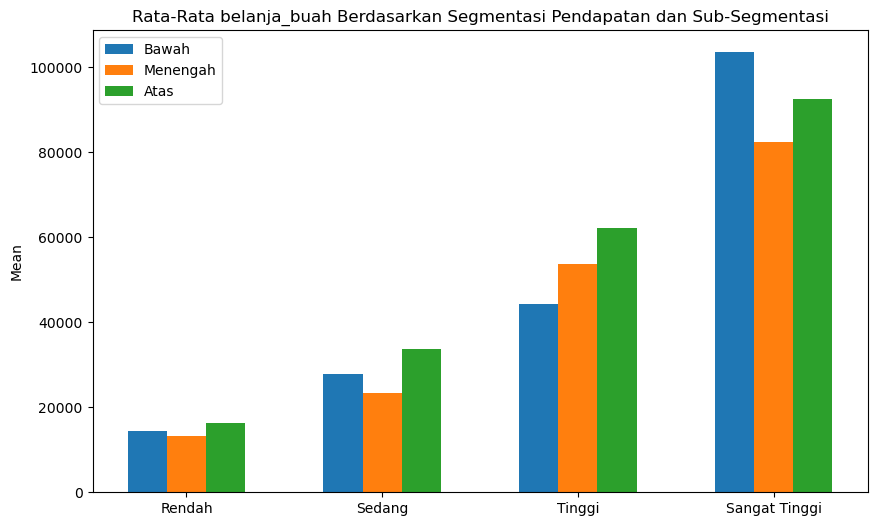

In [158]:
# Kolom Belanja Buah (Mean)
jenis_kolom_belanja = 'belanja_buah'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


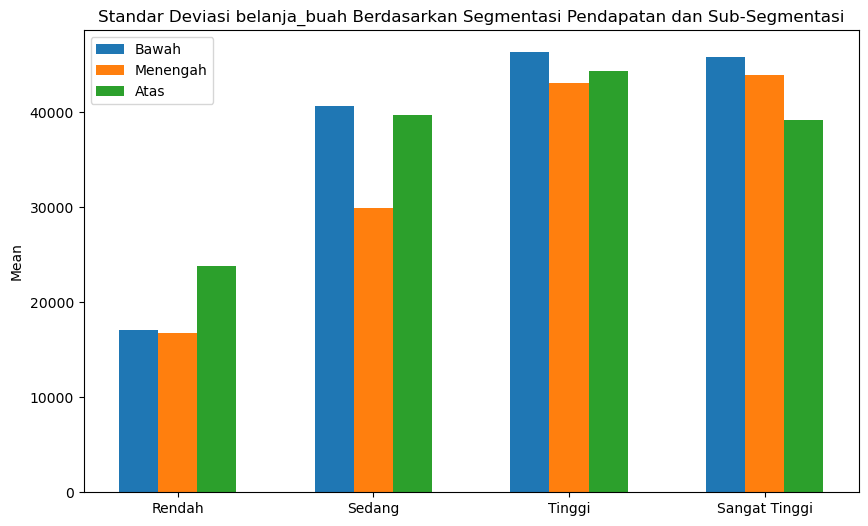

In [159]:
# Kolom Belanja Buah (Std)
jenis_kolom_belanja = 'belanja_buah'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


2. Kolom Belanja Daging

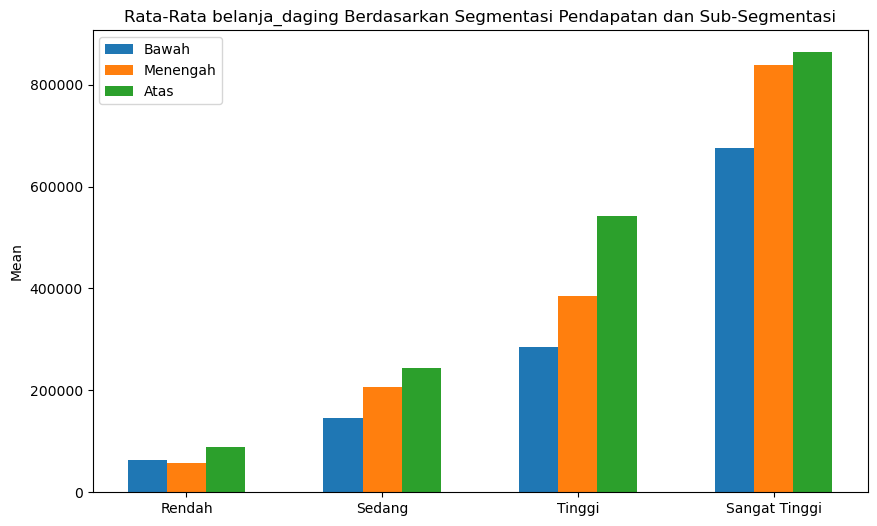

In [160]:
# Kolom Belanja Daging (Mean)
jenis_kolom_belanja = 'belanja_daging'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


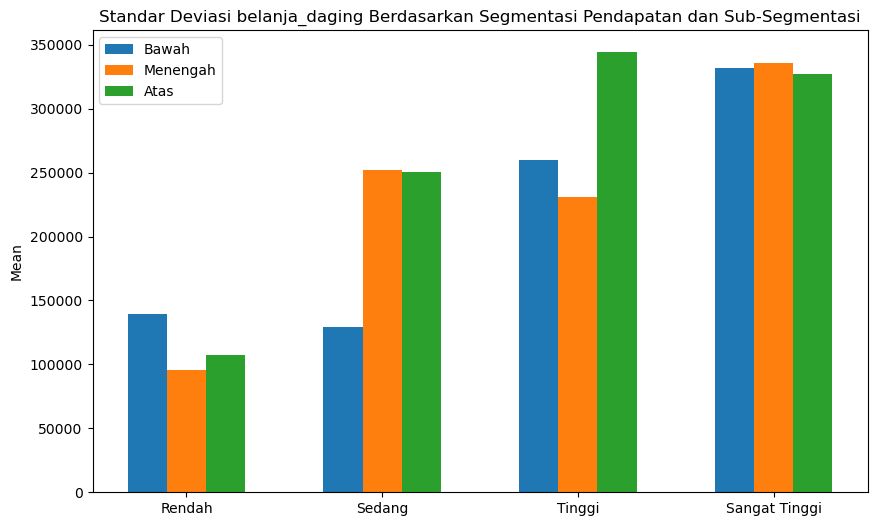

In [161]:
# Kolom Belanja Daging (Std)
jenis_kolom_belanja = 'belanja_daging'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


3. Kolom Belanja Ikan

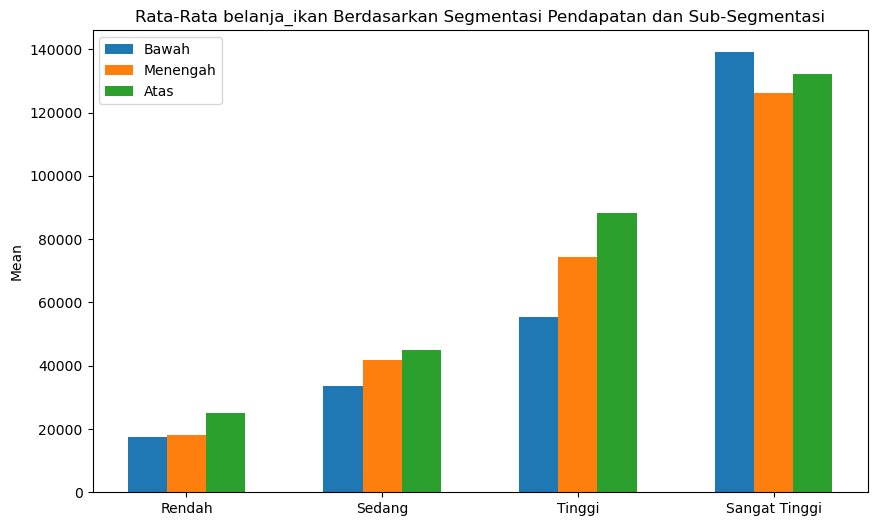

In [162]:
# Kolom Belanja Ikan (Mean)
jenis_kolom_belanja = 'belanja_ikan'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


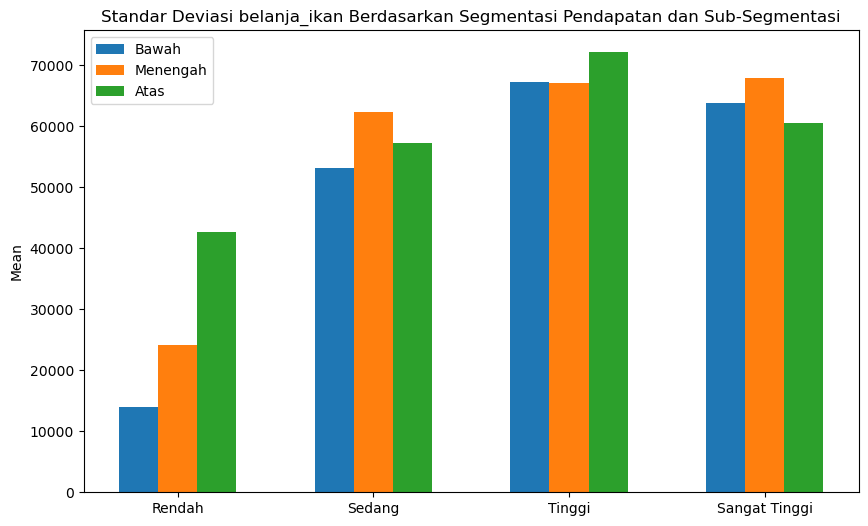

In [163]:
# Kolom Belanja Ikan (Std)
jenis_kolom_belanja = 'belanja_ikan'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


4. Kolom Belanja Kue

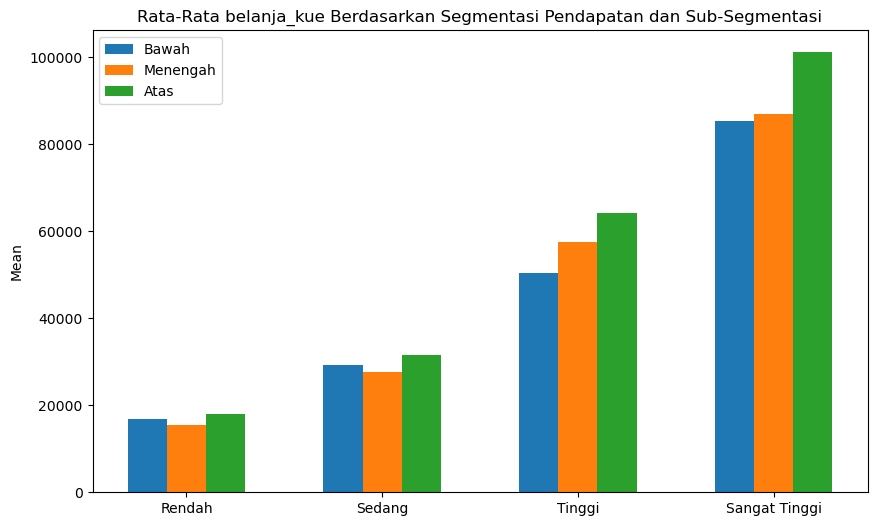

In [164]:
# Kolom Belanja Kue (Mean)
jenis_kolom_belanja = 'belanja_kue'
jenis_statistik = 'mean'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)


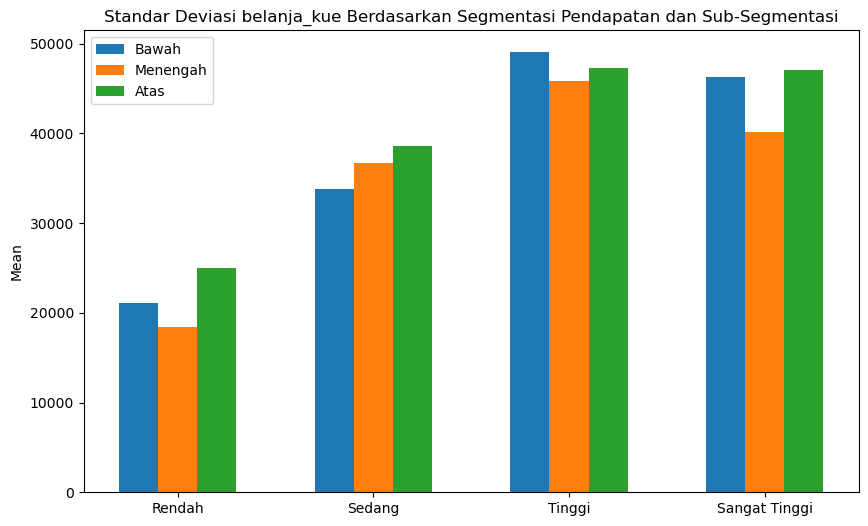

In [165]:
# Kolom Belanja Kue (Std)
jenis_kolom_belanja = 'belanja_kue'
jenis_statistik = 'std'
# Plot
plotStats(nilai_statistik, jenis_kolom_belanja, segmentasi_pendapatan, sub_segmentasi, jenis_statistik)
